## Sliding window

Here we fit the entire Cygnus region using 10 overlappig rectangular sub-regions.
The results are stored in a JSON file. You can both use a Gaussian and a "HESS-like" spatial model.

In [1]:
from gammapy.maps import Map
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ConstantSpectralModel,
    SkyModel,
    DiskSpatialModel,
    GeneralizedGaussianSpatialModel,
    GaussianSpatialModel,
    Models,
)
from gammapy.analysis import Analysis, AnalysisConfig

import os
import glob
import shutil
import json
import time
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# function to add to JSON
def write_json(new_data, filename='sample.json'):
    with open(filename,'r+') as file:
          # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data.update(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)

### Configuration parameters

In [3]:
config = AnalysisConfig()
config.observations.datastore = ("../")
config.observations.obs_cone.frame = "galactic"
config.observations.obs_cone.lat = "2 deg"
config.observations.obs_cone.radius = "5 deg"

config.datasets.type = "3d"
config.datasets.stack = True
config.datasets.geom.wcs.width = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"
config.datasets.geom.axes.energy.max = "20 TeV"
config.datasets.geom.axes.energy.nbins = 10
config.datasets.geom.axes.energy.min = "0.7 TeV"
config.datasets.geom.axes.energy_true.min = "0.1 TeV"
config.datasets.geom.axes.energy_true.max = "20 TeV"
config.datasets.geom.axes.energy_true.nbins = 10
config.datasets.background.parameters = {"method": "scale"}
config.datasets.background.method = "fov_background"
config.fit.fit_range.min = 0.7 * u.TeV
config.fit.fit_range.max = 20 * u.TeV
config.flux_points.energy = {"min": "0.7 TeV", "max": "20 TeV", "nbins": 10}
config.excess_map.correlation_radius = 0.1 * u.deg

### Start of the loop

In [4]:
# Create JSON file
with open(f"sliding_window.json", "w") as outfile:
    json.dump({}, outfile)

# Here you can change the "steps" of the sliding window
for i in np.arange(68, 79, 0.5):
    config.datasets.geom.wcs.skydir = {
        "lon": f"{i} deg",
        "lat": "2.0 deg",
        "frame": "galactic",
    }
    config.observations.obs_cone.lon = f"{i} deg"

    analysis = Analysis(config)
    analysis.get_observations()
    analysis.get_datasets()

    mask_map = Map.read("exclusion_mask.fits")
    mask_map.data = mask_map.data.astype(bool)
    analysis.datasets["stacked"].mask_fit = mask_map

    # Spatial and spectral models
    spectra = 0
    spatial = 1

    if spectra == 0:
        spectral_model = PowerLawSpectralModel(
            index=2,
            amplitude="1e-12 TeV-1 cm-2 s-1",
            reference=1 * u.TeV,
        )
    else:
        spectral_model = ConstantSpectralModel(const="1e1 / (cm2 s TeV)")

    if spatial == 0:
        spatial_model = GaussianSpatialModel(
            lon_0=i * u.deg,
            lat_0=1.5 * u.deg,
            sigma="1 deg",
            e=0.01,
            phi=0 * u.deg,
            frame="galactic",
        )
    elif spatial == 1:
        spatial_model = DiskSpatialModel(
            lon_0=i * u.deg,
            lat_0=1.5 * u.deg,
            r_0="1 deg",
            e=0.01,
            phi=0 * u.deg,
            edge_width=0.1,
            frame="galactic",
        )
    else:
        spatial_model = GeneralizedGaussianSpatialModel(
            lon_0=i * u.deg,
            lat_0=1.5 * u.deg,
            eta=.5,
            r_0=12 * u.deg,
            e=.999,
            phi=90 * u.deg,
            frame="galactic",
        )

    model_config = SkyModel(spectral_model=spectral_model,
                            spatial_model=spatial_model, name="cygnus_background")

    model_config = Models([model_config])
    model_sim = model_config.copy()

    analysis.set_models(model_config, extend=False)
    analysis.models[0].parameters["lon_0"].frozen = True
    if spatial == 1:
        analysis.models[0].parameters["e"].frozen = False
        analysis.models[0].parameters["phi"].frozen = True
        analysis.models[0].parameters["edge_width"].frozen = True
    if spatial != 0 and spatial != 1:
        analysis.models[0].parameters["r_0"].frozen = True
    analysis.models[1].parameters["norm"].frozen = False
    analysis.models[1].parameters["norm"].value = 1

    analysis.run_fit()

    # Data to be written
    if spectra == 0:
        name_spectra = analysis.fit_result.parameters["amplitude"].name
        value_spectra = analysis.fit_result.parameters["amplitude"].value
    else:
        name_spectra = analysis.fit_result.parameters["constant"].name
        value_spectra = analysis.fit_result.parameters["constant"].value
    if spatial == 0:
        name_spatial = analysis.fit_result.parameters["sigma"].name
        value_spatial = analysis.fit_result.parameters["sigma"].value
    elif spatial == 1:
        name_spatial = analysis.fit_result.parameters["r_0"].name
        value_spatial = analysis.fit_result.parameters["r_0"].value
    else:
        name = analysis.fit_result.parameters["eta"].name
        value = analysis.fit_result.parameters["eta"].value

    results = {
        str(analysis.fit_result.parameters["lon_0"].value): {
            "models": [analysis.models[0].spectral_model.tag[0], analysis.models[0].spatial_model.tag[0]],
            "result": [analysis.fit_result.optimize_result.success,
                       analysis.fit_result.optimize_result.message,
                       analysis.fit_result.optimize_result.total_stat],
            name_spectra: value_spectra,
            analysis.fit_result.parameters["lat_0"].name: analysis.fit_result.parameters["lat_0"].value,
            name_spatial: value_spatial,
        },
    }
    if spatial == 1:
        results[str(analysis.fit_result.parameters["lon_0"].value)] |= {
            analysis.fit_result.parameters["phi"].name: analysis.fit_result.parameters["phi"].value,
            analysis.fit_result.parameters["e"].name: analysis.fit_result.parameters["e"].value,
        }

    write_json(results, "results_sliding_window.json")

#Save the last config file to save the analysis parameters
config.write("config_sliding_window.yaml", overwrite=True)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 55 out of 55.
Number of selected observations: 55
Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 3
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 3
No default lower safe energy threshold defined for obs 3
Running FoVBackgroundMaker
Computing dataset for observation 120
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 120
No default lower safe energy threshold defined for obs 120
Running FoVBackgroundMaker
Computing dataset for observation 147
Running MapDatasetMaker
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 147
No default lower safe energy threshold defined for obs 147
Running FoVBackgroundMaker
Computing d

### Checking the results

In [5]:
#Reading the JSON file
with open(f"sliding_window_{timestr}.json") as f:
#with open("sliding_window_20221128-090312.json") as f:
    data = json.load(f)
#Create a list of lists where to store useful results
n_val = len(data[list(data.keys())[0]])
lists = [[] for _ in range(n_val)]
#Fill the list
for key, val in data.items():
    lists[0].append(key)
    ls = list(val.values())
    for i in range(1, n_val): lists[i].append(ls[i])

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

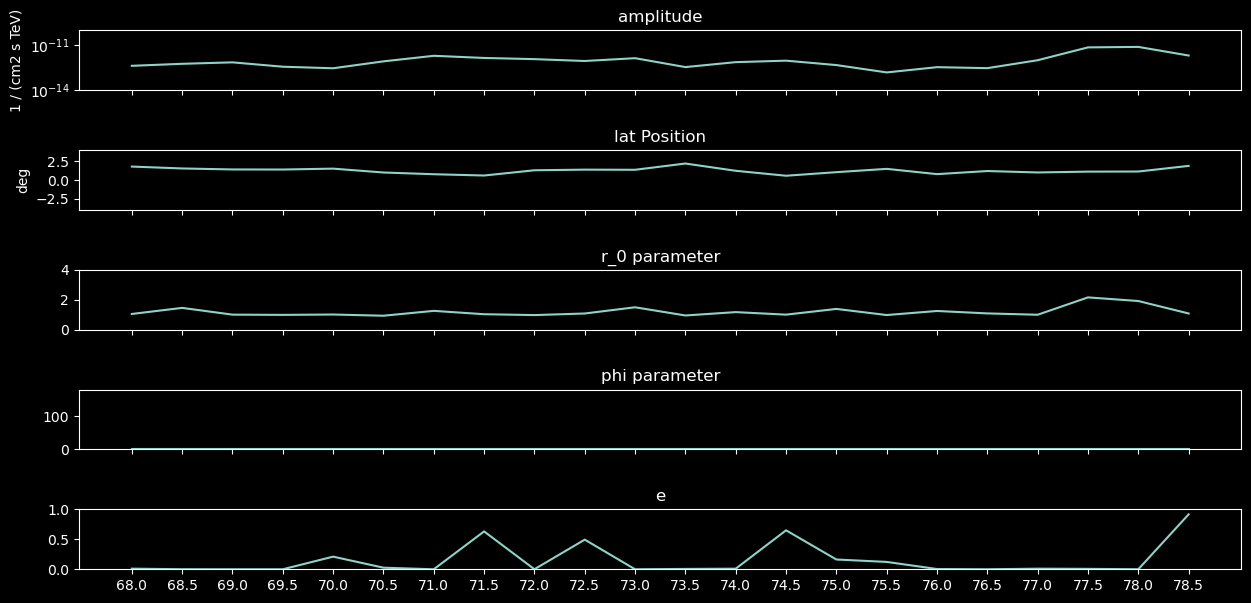

In [6]:
#Plot the results
fig, ax = plt.subplots(len(lists)-2, 1, sharex='col', sharey='row', figsize=(15, 7))
fig.subplots_adjust(hspace=1, wspace=1)

ax[0].semilogy(lists[0], lists[2])
ax[0].set_ylim(1.e-14, 1.e-10)
if spectra == 0:
    ax[0].set_title("amplitude")
else:
    ax[0].set_title("const")
ax[0].set_ylabel("1 / (cm2 s TeV)")

ax[1].plot(lists[0], lists[3])
ax[1].set_ylim(-4, 4)
ax[1].set_title("lat Position")
ax[1].set_ylabel("deg")

ax[2].plot(lists[0], lists[4])
ax[2].set_ylim(0, 4)
if spatial == 0:
    ax[2].set_title("Sigma parameter")
elif spatial == 1:
    ax[2].set_title("r_0 parameter")
    ax[3].plot(lists[0], lists[5])
    ax[3].set_ylim(0, 180)
    ax[3].set_title("phi parameter")
    ax[4].plot(lists[0], lists[6])
    ax[4].set_ylim(0, 1)
    ax[4].set_title("e")
else:
    ax[3].set_title("Eta parameter")

# Combine all the operations and display
plt.show()


### Saving the results in a dedicated folder

In [12]:
timestr = time.strftime("%Y%m%d-%H%M%S")
os.makedirs(f"{timestr}", exist_ok = True)

files = glob.glob(f"*_sliding_window*")
for file in files:
    # extract file name form file path
    file_name = os.path.basename(file)
    shutil.move(file, f"{timestr}/" + file_name)
    print('Moved:', file)

Moved: results_sliding_window.json
